# Playground ImageNet

In [42]:
import argparse
import numpy as np
from PIL import Image
import pickle
from utils import *
import os
import matplotlib as mpl
mpl.use('Agg')
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import numpy as np
import argparse
import math
import os
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm import tqdm

In [60]:
###  NOW  IMAGENET64

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
    return dict

def create_tuples(x,y, im_size):
    samps = []

    for i in np.arange(0,len(x),1):
        t = torch.Tensor(x[i]).view(3,64,64)
        tup = (t, int(y[i]))
        samps.append(tup)
    return samps

def create_tuples_test(x,y, im_size):
    samps = []

    for i in np.arange(0,len(x),1):
        t = torch.Tensor(x[i]).view(3,64,64)
        tup = (t, int(y[i]))
        samps.append(tup)
    return samps


def load_data_train(input_file, im_size):

    d = unpickle(input_file)
    x = d['data']
    y = d['labels']
    mean_image = d['mean']
    print('load_data_train', (x).shape)

    x = np.divide(x,np.float32(255))
    mean_image = mean_image/np.float32(255)

    y = [i-1 for i in y]
    x -= mean_image

    img_size = im_size
    img_size2 = img_size * img_size
  
    x = np.dstack((x[:, :img_size2], x[:, img_size2:2*img_size2], x[:, 2*img_size2:])) # x has shape (128116, 1024, 3)
    x = x.reshape((x.shape[0], img_size, img_size, 3)) #.transpose(0, 3, 1, 2) # np.ndarray with shape (128116, 3, 32, 32) or (128116, 32, 32, 3)

    return x, y

def load_data_test(input_file, im_size):

    d = unpickle(input_file)
    x = d['data']
    y = d['labels']
    print('load_data_test', (x).shape)

    x = np.divide(x,np.float32(255))

    # Labels are indexed from 1, shift it so that indexes start at 0
    y = [i-1 for i in y]

    img_size = im_size
    img_size2 = img_size * img_size

    x = np.dstack((x[:, :img_size2], x[:, img_size2:2*img_size2], x[:, 2*img_size2:]))
    x = x.reshape((x.shape[0], img_size, img_size, 3)) #.transpose(0, 3, 1, 2)  # shape (50000, 32, 32, 3)

    return x, y

def get_train_dat(p, im_size):

    path = p
    counter = 0

    transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize([64, 64])
            ]
        )

    for i in os.listdir(path):
        counter += 1
        print(counter)
        total_path = path + i

        x,y = load_data_train(total_path, im_size)
        x = np.array([transform(i) for i in x])

        if counter == 1:
            x_train, y_train = x, y
        else:
            break
            x_train = np.append(x_train, x, axis = 0)
            y_train = y_train + y
    
    # x_train = x_train[:100]
    # x_train = np.array([transform(Image.fromarray(np.uint8((i)*255))) for i in x_train])
    # x_train = np.array([transform(i) for i in x_train])
    print('type x_train:', type(x_train))
    print('x_train shape:', x_train.shape)
        
    return x_train, y_train # x_train np.array with shape 128116, 3, 32, 32)

def get_test_dat(p, im_size):
    if im_size == 32:
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize([64, 64]),
            transforms.Normalize(
                mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225]) 
            ]
        )

    if im_size == 64:
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225]) 
            ]
        )
    
    x_test, y_test = load_data_test(p, im_size) # x_test is np.ndarry with shape (50000, 32, 32, 3)
    print('x_test type', type(x_test))
    print('x_test shape:', x_test.shape)
    x_test = np.array([transform(i) for i in x_test])
    return x_test, y_test

def create_imnet_train_test(path_train, path_test, batch_size, im_size):
    x_train, y_train = get_train_dat(path_train, im_size)
    dat_train = create_tuples(x_train, y_train, im_size)
    trainset = torch.utils.data.DataLoader(dat_train, batch_size = batch_size, shuffle = False)

    x_test,y_test = get_test_dat(path_test, im_size)
    dat_test = create_tuples_test(x_test, y_test, im_size)
    testset = torch.utils.data.DataLoader(dat_test, batch_size = batch_size, shuffle = False)

    return trainset, testset

# 32 

In [61]:
path_train = '/Users/dj/Desktop/MT_Desktop/ImageNet/Imagenet32_train/playground/'
path_test = '/Users/dj/Desktop/MT_Desktop/ImageNet/val_data'

trainset, testset = create_imnet_train_test(path_train= path_train,
                                             path_test=path_test,
                                                 batch_size = 128,
                                                  im_size = 32) # im_size_rescaled = 224

1
load_data_train (128116, 3072)


/opt/anaconda3/envs/MasterThesis/lib/python3.7/site-packages/ipykernel_launcher.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/opt/anaconda3/envs/MasterThesis/lib/python3.7/site-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


type x_train: <class 'numpy.ndarray'>
x_train shape: (128116,)
load_data_test (50000, 3072)
x_test type <class 'numpy.ndarray'>
x_test shape: (50000, 32, 32, 3)


/opt/anaconda3/envs/MasterThesis/lib/python3.7/site-packages/ipykernel_launcher.py:126: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/opt/anaconda3/envs/MasterThesis/lib/python3.7/site-packages/ipykernel_launcher.py:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [62]:
type(trainset)

torch.utils.data.dataloader.DataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
tensor(0.0384)
torch.Size([3, 64, 64])
56


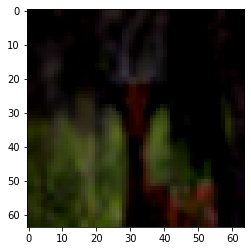

In [63]:
for idx, data in enumerate(trainset.dataset):
    x,y = data
    if idx == 6:
        print(type(x))
        print(torch.mean(x))
        print(x.shape)
        print(y)
        plt.imshow(x.permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0384)
torch.Size([3, 224, 224])
56
<class 'tuple'>


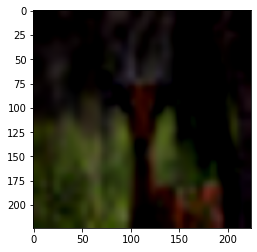

In [64]:
transform_train =transforms.Compose([
            transforms.Resize([224, 224])
            ]            
        )

for idx, data in enumerate(trainset.dataset):
    x,y = data
    if idx == 6:
        x = transform_train(x)
        print(torch.mean(x))
        print(x.shape)
        print(y)
        plt.imshow(x.permute(1, 2, 0))
        print(type(trainset.dataset[idx]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0384)
torch.Size([3, 64, 64])
56


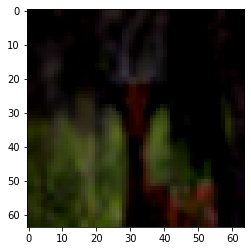

In [65]:
for idx, data in enumerate(trainset.dataset):
    x,y = data
    if idx == 6:
        print(torch.mean(x))
        print(x.shape)
        print(y)
        plt.imshow(x.permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0451)
torch.Size([3, 64, 64])
662


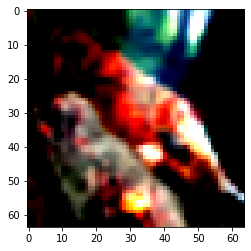

In [66]:
for idx, data in enumerate(testset.dataset):
    x,y = data
    if idx == 6:
        print(torch.mean(x))
        print(x.shape)
        print(y)
        plt.imshow(x.permute(1, 2, 0))
        break

In [67]:
transform_test =transforms.Compose([
            transforms.Resize([224, 224])
            ]            
        )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.0451)
torch.Size([3, 224, 224])
662


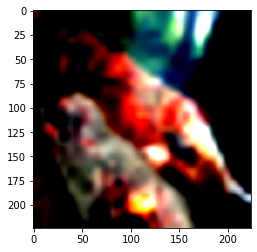

In [68]:
for idx, data in enumerate(testset.dataset):
    x,y = data
    if idx == 6:
        x = transform_test(x)
        print(torch.mean(x))
        print(x.shape)
        print(y)
        plt.imshow(x.permute(1, 2, 0))
        break

# Saving

In [69]:
# Save datasets 
current_path = '/Users/dj/desktop'
dat_path = (current_path + '/data/')

dir = f'torch_imnet_{32}'
final_dat_path = (dat_path + dir)
if not os.path.exists(final_dat_path):
    os.mkdir(final_dat_path)
torch.save(trainset, os.path.join(final_dat_path, "imnet_train.pth"))
torch.save(testset, os.path.join(final_dat_path, "imnet_test.pth"))

In [72]:
7*3.95

27.650000000000002

In [73]:
27.65*0.65 # For 50k images - 18 GB

17.9725

In [75]:
20*18

360

In [34]:
t = np.array([[ 0.4616,  0.4861,  0.4841,  0.4879,  0.5093,  0.5120],
         [ 0.4618,  0.4875,  0.4861,  0.4821,  0.5068,  0.5084],
         [ 0.4552,  0.4778,  0.4813,   0.4850,  0.5050,  0.5059],
         [ 0.1262,  0.0679, -0.0563,  0.5088,  0.5232,  0.4990],
         [ 0.1602, -0.0050,  0.2031,    0.5089,  0.5243,  0.4976],
         [ 0.1911,  0.1188,  0.4278,  0.5104,  0.5151,  0.5052]])

In [40]:
from PIL import Image
from matplotlib import cm
im = Image.fromarray(np.uint8(t*255))

In [41]:
type(im)

PIL.Image.Image

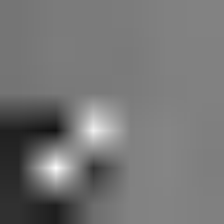

In [42]:
transform_test(im)

# 64

In [76]:
path_train = '/Users/dj/Desktop/MT_Desktop/ImageNet/ImageNet64/Imagenet64_train/'
path_test = '/Users/dj/Desktop/MT_Desktop/ImageNet/ImageNet64/val_data'

trainset, testset = create_imnet_train_test(path_train= path_train,
                                             path_test=path_test,
                                                 batch_size = 128,
                                                  im_size = 64)

1
load_data_train (128116, 12288)


/opt/anaconda3/envs/MasterThesis/lib/python3.7/site-packages/ipykernel_launcher.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/opt/anaconda3/envs/MasterThesis/lib/python3.7/site-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


2
load_data_train (128116, 12288)
type x_train: <class 'numpy.ndarray'>
x_train shape: (128116,)
load_data_test (50000, 12288)
x_test type <class 'numpy.ndarray'>
x_test shape: (50000, 64, 64, 3)


/opt/anaconda3/envs/MasterThesis/lib/python3.7/site-packages/ipykernel_launcher.py:126: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/opt/anaconda3/envs/MasterThesis/lib/python3.7/site-packages/ipykernel_launcher.py:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [95]:
z = np.zeros(1000)
for idx, data in enumerate(trainset.dataset):
    x,y = data
    z[y] += 1

In [100]:
min(z); max(z)

169.0

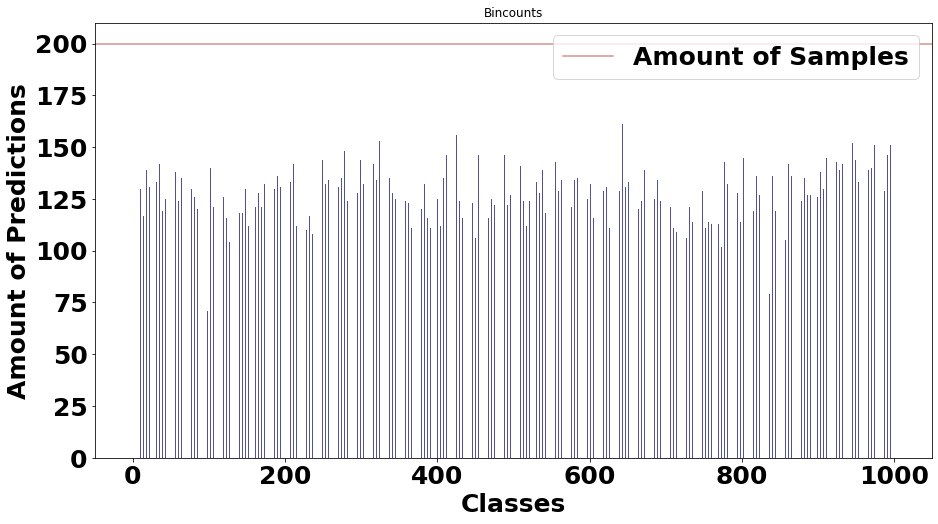

In [98]:
fig = plt.figure(figsize=(15,8))
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.bar(np.arange(0,1000,1),z, color='midnightblue', width=0.2, alpha=0.75)
plt.axhline(y=200, label= 'Amount of Samples', color = 'firebrick', alpha=0.5)
plt.legend(prop={'size': 25}, loc=1)
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlabel('Classes', size = 25)
plt.ylabel('Amount of Predictions', size = 25)
plt.title('Bincounts')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1106)
torch.Size([3, 64, 64])
<class 'int'>


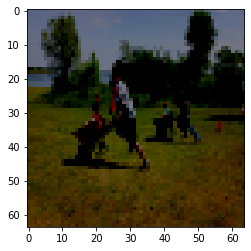

In [94]:
for idx, data in enumerate(trainset.dataset):
    x,y = data
    if idx == 1:
        print(torch.mean(x))
        print(x.shape)
        print(type(y))
        plt.imshow(x.permute(1, 2, 0))
        break

In [7]:
# path = '/Users/dj/Desktop/MT_Desktop/ImageNet/Imagenet32_train/'

# load_databatch(path, 1, img_size=32)

In [8]:
path = '/Users/dj/Desktop/MT_Desktop/ImageNet/Imagenet32_train/train_data_batch_1'

In [9]:
x,y = load_data_train(path)

In [10]:
np.mean(x)

-0.0005127891

In [11]:
# a_set = set(y)
# number_of_unique_values = len(a_set)
# print(number_of_unique_values)

# Gettin TEST data

In [8]:
x_test,y_test = load_data_test('/Users/dj/Desktop/MT_Desktop/ImageNet/val_data', im_size = 32)
print(type(x_test))
print(type(y_test))
dat_test = create_tuples(x_test, y_test, im_size = 32)
print(type(dat_test))

<class 'numpy.ndarray'>
<class 'list'>
<class 'list'>


In [9]:
print((x_test[0].shape))
print((y_test[0]))

(3, 32, 32)
371


662


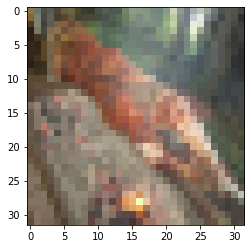

In [17]:
s = 6
image = torch.tensor(x_test[s]) #34
print(y_test[s])
plt.imshow(image.permute(1, 2, 0))

# Average Calculations - 32

In [24]:
from torch.utils.data import DataLoader

image_data_loader = DataLoader(
  dat_test, 
  # batch size is whole datset
  batch_size=len(dat_test), 
  shuffle=False, 
  num_workers=0)

def mean_std(loader):
  images, labels = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std

mean1, std1 = mean_std(image_data_loader)
print("mean and std: \n", mean1, std1)

mean and std: 
 tensor([0.4656, 0.4361, 0.4225]) tensor([0.2732, 0.2491, 0.2550])


In [14]:
# Approach for BATCHES
import torch
from torch.utils.data import DataLoader

batch_size = 100

loader = DataLoader(
  dat_test, 
  batch_size = batch_size, 
  num_workers=1)

def batch_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)        
    return mean,std
  
mean2, std2 = batch_mean_and_sd(loader)
print("mean and std: \n", mean2, std2)

mean and std: 
 tensor([0.4656, 0.4361, 0.4225]) tensor([0.2732, 0.2491, 0.2550])


In [17]:
transform=transforms.Compose([
    transforms.ToTensor(),
	transforms.Normalize(
        mean = mean1,
        std = std1)
    ]
)

In [18]:
torch.mean(transform(x_test[10]))

tensor(-0.0016)

In [19]:
means= []
for i in np.arange(0,len(x_test),1):
    means.append(torch.mean(transform(x_test[i])))

In [20]:
np.mean(means)

-0.00021054603

# Average Calculations - 64

In [25]:
x_test,y_test = load_data_test('/Users/dj/Desktop/MT_Desktop/ImageNet/ImageNet64/val_data', im_size = 64)
print(type(x_test))
print(type(y_test))
dat_test = create_tuples(x_test, y_test, im_size = 64)
print(type(dat_test))

<class 'numpy.ndarray'>
<class 'list'>
<class 'list'>


In [26]:
from torch.utils.data import DataLoader

image_data_loader = DataLoader(
  dat_test, 
  # batch size is whole datset
  batch_size=len(dat_test), 
  shuffle=False, 
  num_workers=0)

def mean_std(loader):
  images, labels = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std

mean1, std1 = mean_std(image_data_loader)
print("mean and std: \n", mean1, std1)

mean and std: 
 tensor([0.4660, 0.4363, 0.4231]) tensor([0.2806, 0.2582, 0.2627])


In [62]:
for images, _ in dat_test:
    print(images.shape)
    print(_)
    break

torch.Size([3, 32, 32])
371


In [63]:
for images, _ in loader:
    b, c, h, w = images.shape
    print(b)
    print(c)
    print(h)
    print(w)
    break

64
3
32
32


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


In [4]:
# Create both datasets
batch_size = 100
train = '/Users/dj/Desktop/MT_Desktop/ImageNet/Imagenet32_train/'
test = '/Users/dj/Desktop/MT_Desktop/ImageNet/val_data'
trainset, testset = create_imnet_train_test(path_train= train, path_test=test)

/opt/anaconda3/envs/MasterThesis/lib/python3.7/site-packages/ipykernel_launcher.py:82: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/opt/anaconda3/envs/MasterThesis/lib/python3.7/site-packages/ipykernel_launcher.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
from torch.utils.data import DataLoader

def mean_std(loader):
  images, labels = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std

mean1, std1 = mean_std(testset)
print("mean and std: \n", mean1, std1)

mean and std: 
 tensor([0.4578, 0.4381, 0.4403]) tensor([0.2750, 0.2450, 0.2628])


In [8]:
for data in testset:
    x,y = data
    print(x)
    break

tensor([[[[-0.1683,  0.0900,  0.1331,  ..., -0.1253, -0.1109, -0.1396],
          [-0.2832,  0.0326,  0.0900,  ..., -0.0966, -0.0966, -0.0679],
          [-0.4985, -0.1396,  0.0183,  ..., -0.0248, -0.0104, -0.0104],
          ...,
          [-0.8430, -0.8143, -0.8143,  ..., -0.8861, -0.8430, -0.8430],
          [-0.8861, -0.9004, -0.8861,  ..., -1.0009, -1.0152, -1.0583],
          [-1.1731, -1.1157, -1.0583,  ..., -1.0296, -1.0440, -1.0152]],

         [[-0.3653, -0.1449, -0.0977,  ..., -0.1607, -0.1449, -0.1449],
          [-0.4598, -0.1764, -0.0819,  ..., -0.1607, -0.1449, -0.1292],
          [-0.6487, -0.3181, -0.1764,  ..., -0.1134, -0.0977, -0.0819],
          ...,
          [-1.0423, -1.0265, -1.0108,  ..., -0.9950, -0.9636, -0.9478],
          [-1.0738, -1.1052, -1.0738,  ..., -1.0895, -1.1210, -1.1525],
          [-1.1367, -1.1840, -1.1840,  ..., -1.1052, -1.1210, -1.1052]],

         [[-0.7649, -0.5496, -0.5035,  ..., -0.3804, -0.3343, -0.3343],
          [-0.8110, -0.5496, -

In [8]:
transform=transforms.Compose([
    transforms.ToTensor(),
	transforms.Normalize(
        mean = [0.4656, 0.4361, 0.4225],
        std = [0.2732, 0.2491, 0.2550])
    ]
)

In [14]:
test = np.array([transform(i) for i in x_test])

/opt/anaconda3/envs/MasterThesis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/MasterThesis/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [16]:
test[0]

tensor([[[-0.1683,  0.0900,  0.1331,  ..., -0.1253, -0.1109, -0.1396],
         [-0.2832,  0.0326,  0.0900,  ..., -0.0966, -0.0966, -0.0679],
         [-0.4985, -0.1396,  0.0183,  ..., -0.0248, -0.0104, -0.0104],
         ...,
         [-0.8430, -0.8143, -0.8143,  ..., -0.8861, -0.8430, -0.8430],
         [-0.8861, -0.9004, -0.8861,  ..., -1.0009, -1.0152, -1.0583],
         [-1.1731, -1.1157, -1.0583,  ..., -1.0296, -1.0440, -1.0152]],

        [[-0.3653, -0.1449, -0.0977,  ..., -0.1607, -0.1449, -0.1449],
         [-0.4598, -0.1764, -0.0819,  ..., -0.1607, -0.1449, -0.1292],
         [-0.6487, -0.3181, -0.1764,  ..., -0.1134, -0.0977, -0.0819],
         ...,
         [-1.0423, -1.0265, -1.0108,  ..., -0.9950, -0.9636, -0.9478],
         [-1.0738, -1.1052, -1.0738,  ..., -1.0895, -1.1210, -1.1525],
         [-1.1367, -1.1840, -1.1840,  ..., -1.1052, -1.1210, -1.1052]],

        [[-0.7649, -0.5496, -0.5035,  ..., -0.3804, -0.3343, -0.3343],
         [-0.8110, -0.5496, -0.4881,  ..., -0

In [17]:
transform(x_test[0])

tensor([[[-0.1683,  0.0900,  0.1331,  ..., -0.1253, -0.1109, -0.1396],
         [-0.2832,  0.0326,  0.0900,  ..., -0.0966, -0.0966, -0.0679],
         [-0.4985, -0.1396,  0.0183,  ..., -0.0248, -0.0104, -0.0104],
         ...,
         [-0.8430, -0.8143, -0.8143,  ..., -0.8861, -0.8430, -0.8430],
         [-0.8861, -0.9004, -0.8861,  ..., -1.0009, -1.0152, -1.0583],
         [-1.1731, -1.1157, -1.0583,  ..., -1.0296, -1.0440, -1.0152]],

        [[-0.3653, -0.1449, -0.0977,  ..., -0.1607, -0.1449, -0.1449],
         [-0.4598, -0.1764, -0.0819,  ..., -0.1607, -0.1449, -0.1292],
         [-0.6487, -0.3181, -0.1764,  ..., -0.1134, -0.0977, -0.0819],
         ...,
         [-1.0423, -1.0265, -1.0108,  ..., -0.9950, -0.9636, -0.9478],
         [-1.0738, -1.1052, -1.0738,  ..., -1.0895, -1.1210, -1.1525],
         [-1.1367, -1.1840, -1.1840,  ..., -1.1052, -1.1210, -1.1052]],

        [[-0.7649, -0.5496, -0.5035,  ..., -0.3804, -0.3343, -0.3343],
         [-0.8110, -0.5496, -0.4881,  ..., -0

In [ ]:
    # # Normalization.
    # mrgb = [0.4656, 0.4361, 0.4225]
    # srgb = [0.2732, 0.2491, 0.2550]
    # normalize = transforms.Normalize(mean=mrgb, std=srgb)

    # # Train loader.
    # train_data = datasets.ImageFolder(basedir + "train/", transform=transforms.Compose(
    #     [transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor(), normalize]))

    # trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)

    # # Test loader.
    # test_data = datasets.ImageFolder(basedir + "test/", transform=transforms.Compose(
    #     [transforms.RandomResizedCrop(224), transforms.ToTensor(), normalize]))

    # testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)